In [4]:
import os
import cv2
import h5py
import torch
import numpy as np
import scipy.io as io
from PIL import Image
import matplotlib.pyplot as plt
import utils, metrics, models, io_img, core, plot, dynamics, preprocess, main
from io_img import logger_setup

# 1. Load Datasets

## 1.1 Load Image, Cell Instance Mask and Gene expressions

In [5]:
#Load original image
root_dir = "./datasets/original_data"
image = cv2.imread("{}/image/DAPI_3-4_right.jpg".format(root_dir))
image = image[..., [2,1,0]] #convert BGR into RGB

#Load initial cell instance mask
label = h5py.File("{}/label/label_3-4_right.mat".format(root_dir), 'r')
label = np.array(label['CellMap']).transpose()

#Load gene expressions
with open("{}/spots/DAPI_spots_3-4_right.csv".format(root_dir), 'r') as f:
            lines = f.readlines()
            lines = lines[1:]

spot_list = []
for line in lines:
    splits = line.split(',')
    spot_list.append([splits[0], splits[1], splits[2]])
        
spot = np.array(spot_list)

## 1.2 Visualize Image, Cell Instance Mask and Gene expressions

(-0.5, 7521.5, 3033.5, -0.5)

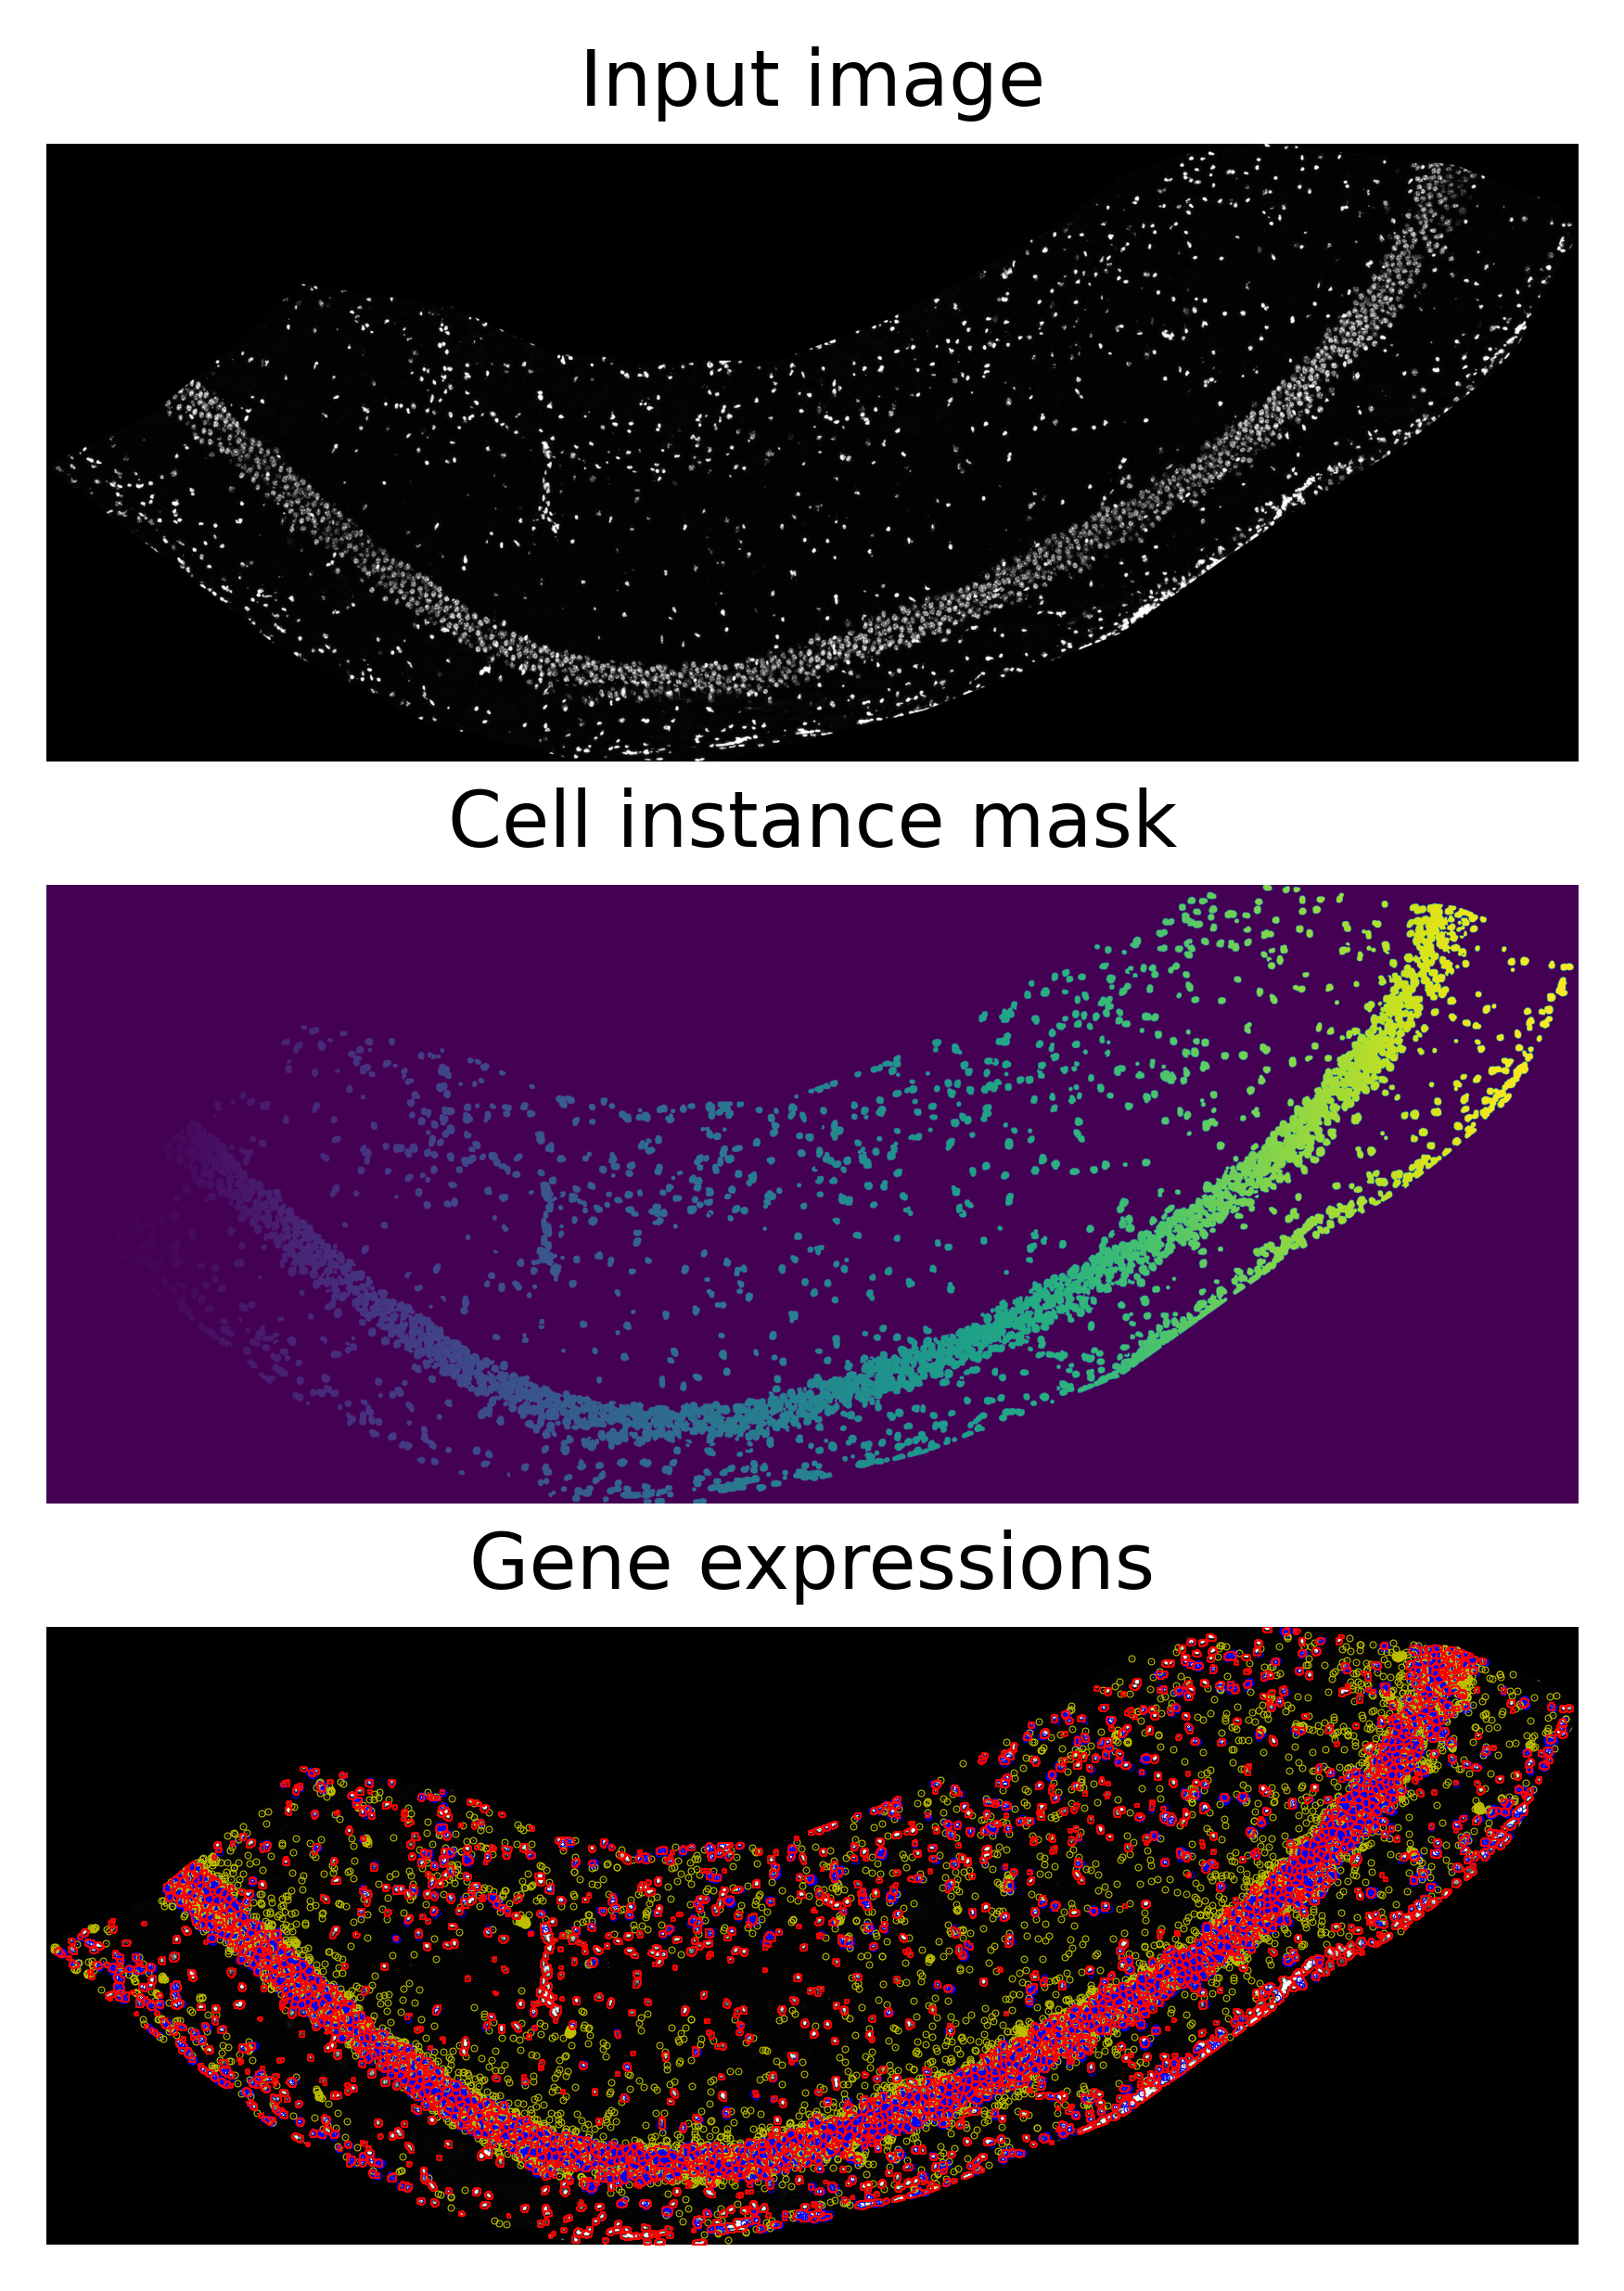

In [12]:
fig = plt.figure(figsize=(8,6), dpi=500)

lbout = label.copy()
imgout= image.copy()
spotout = spot[:,1:].astype(np.float64).astype(np.int32)
 
ax = fig.add_subplot(3,1,1)
ax.imshow(imgout)
ax.set_title('Input image')
ax.axis('off')
    
ax = fig.add_subplot(3,1,2)
ax.imshow(lbout)
ax.set_title('Cell instance mask')
ax.axis('off')

ax = fig.add_subplot(3,1,3)
outlines = utils.masks_to_outlines(lbout)
outX, outY = np.nonzero(outlines)

xs = spotout[:,0]
ys = spotout[:,1]

cell_in_mask = lbout[ys,xs] != 0
cell_out_mask = lbout[ys,xs] == 0
cell_in_spots = spotout[cell_in_mask]
cell_out_spots = spotout[cell_out_mask]

if len(cell_in_spots) != 0:
    ax.scatter(cell_in_spots[:,0],cell_in_spots[:,1], marker='.', c='b', s=0.1)
    
if len(cell_out_spots) != 0:
    ax.scatter(cell_out_spots[:,0], cell_out_spots[:,1], marker='.',c='y', s=0.1)

ax.scatter(outY, outX, marker = ',' , c='r', lw=0, s=0.1)
ax.imshow(imgout)
ax.set_title('Gene expressions')
ax.axis('off')

# 2. Preprocess Datasets 

## 2.1  Parameter configuration

In [13]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#Radius hyperparameter for generating Gaussian map    
sigma = 7
#The window size to execute SlidingWindow inference
roi_size = [256,256]
#The batch size to run window slices
sw_batch_size = 10
save_dir = "./datasets/cropped_data"

## 2.2 Preprocessing

In [14]:
#Crop image, cell instance mask and spot with Gaussion map generation
#Save cropped data into a path
C_images, C_labels, C_spots, C_gaussian, C_gaussian_all = preprocess.preprocessing(image, label, spot, 
                                                                                   sigma, roi_size, sw_batch_size, 
                                                                                   save_dir, device)

saved_image_path: ./datasets/cropped_data\images
saved_label_path: ./datasets/cropped_data\labels
saved_spot_path: ./datasets/cropped_data\spots
saved_gaumap_path: ./datasets/cropped_data\GauMaps
The number of cropped image is 416
C_images: torch.Size([416, 3, 256, 256])
C_labels: torch.Size([416, 1, 256, 256])
C_gaussian: torch.Size([416, 1, 256, 256])
C_gaussian_all: torch.Size([416, 1, 256, 256])
C_spots: 416


## 2.3 Visualize preprocessing data

In [84]:
# fig = plt.figure(figsize=(50,50), dpi=200)
fig, ax = plt.subplots(len(index), 4, constrained_layout=True, figsize=(45,70), dpi=200)
#fig.tight_layout()
index = [27, 59, 122, 173, 196, 399]

label_batch = C_labels[index].squeeze().cpu().numpy().copy()
img_batch = C_images[index].permute((0,2,3,1)).cpu().numpy().copy()
spot_batch = np.array([spot.cpu().numpy().astype(np.float64).astype(np.int32) for spot in C_spots], dtype=object)[index].copy()
gaussian_btach = C_gaussian[index].squeeze().cpu().numpy().copy()

ax[0, 0].set_title('Cropped \n image',  fontdict={'fontsize': 100, 'fontweight': 'medium'})
ax[0, 1].set_title('Cropped \n label',  fontdict={'fontsize': 100, 'fontweight': 'medium'})
ax[0, 2].set_title('Cropped \n GeneExps',  fontdict={'fontsize': 100, 'fontweight': 'medium'})
ax[0, 3].set_title('Gaussian \n map',  fontdict={'fontsize': 100, 'fontweight': 'medium'})

for i, (lb, img, spot, gm) in enumerate(zip(label_batch, img_batch, spot_batch, gaussian_btach)):
    ax[i, 0].imshow(img)
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(lb)
    ax[i, 1].axis('off')
    
    outlines = utils.masks_to_outlines(lb)
    outX, outY = np.nonzero(outlines)

    xs = spot[:,0]
    ys = spot[:,1]

    cell_in_mask = lb[ys,xs] != 0
    cell_out_mask = lb[ys,xs] == 0
    cell_in_spots = spot[cell_in_mask]
    cell_out_spots = spot[cell_out_mask]
    
    if len(cell_in_spots) != 0:
        ax[i, 2].scatter(cell_in_spots[:,0],cell_in_spots[:,1], marker='o', c='b', s=300)
    
    if len(cell_out_spots) != 0:
        ax[i, 2].scatter(cell_out_spots[:,0], cell_out_spots[:,1], marker='o',c='y', s=300)
    
    ax[i, 2].scatter(outY, outX, marker = ',' , c='r', lw=0, s=50)
    ax[i, 2].imshow(img)
    ax[i, 2].axis('off')
    
    gm = cv2.applyColorMap((gm*255).astype(np.uint8), cv2.COLORMAP_JET)[...,[2,1,0]]
    ax[i, 3].imshow(gm)
    ax[i, 3].axis('off')

# 3. Training

#### Here, we just use small datasets to show training process. If you want better training results, you need to preprocess at least 3000 images 